In [1]:
import scrapy
from scrapy.crawler import CrawlerRunner
from crochet import setup, wait_for
import json
import logging
import re
import seaborn as sns
import unihandecode
import pipe
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pipe import select

In [2]:
# inicializar la librería crochet
setup()

In [3]:
from itemadapter import ItemAdapter

class JsonWriterPipeline:

    def open_spider(self, spider):
        self.file = open('tokens.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(ItemAdapter(item).asdict()) + "\n"
        self.file.write(line)
        return item

In [4]:
class WikiSpider(scrapy.Spider):
    name = 'wiki'
    allowed_domains = ['en.wikipedia.org']
    start_urls = ['https://en.wikipedia.org/wiki/Wikipedia:Featured_articles']

    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1},
        'FEED_FORMAT': 'json',
        'FEED_URI': 'token_list.json'
    }

    def parse(self, response):
        i = 0
        for link in response.css('.featured_article_metadata > a'):
            yield response.follow(link.attrib.get('href'), callback=self.parse_article_data)
            i += 1
            if i == 600: # Solo leer el primer link
                break

    def parse_article_data(self, response):

        def conv(org_list, seperator=' '):
            return seperator.join(org_list).lower()

        contenido = response.xpath('/html/body')
        for parrafo in contenido:
            lista_parrafo_grande = parrafo.xpath('//p//text()').getall()
            sin_unicode = list(lista_parrafo_grande | select(lambda x: unihandecode.unidecode(x)))
            sin_especial = [re.sub('[^a-zA-Z0-9]+|[\]\[\b\d+\b]', ' ', _) for _ in sin_unicode]
            sin_espacios = list(sin_especial | select(lambda x: x.strip()))
            sin_blancos = [x for x in sin_espacios if x]
            sin_dobles = [re.sub(r' +', ' ', string) for string in sin_blancos]
            parrafo_grande = conv(sin_dobles)

        yield {
                'texto': parrafo_grande
            }

In [5]:
def run_spider():
    crawler = CrawlerRunner()
    d = crawler.crawl(WikiSpider)
    return d

In [6]:
run_spider()

In [7]:
# !cat tokens.jl
# https://bit.ly/3NOEsmL

In [8]:
# !tail -n 2 token_list.json

In [9]:
f = open('token_list.json')
data = json.load(f)
f.close()

JSONDecodeError: Expecting ',' delimiter: line 22 column 44703 (char 523874)

In [12]:
len(data)

600

In [13]:
type(data)

list

In [ ]:
data

In [15]:
lista = ' '.join(str(e) for e in data)

In [16]:
type(lista)

str

In [17]:
len(lista)

15547403

In [18]:
lista[0:50]

"{'texto': 'world trade center wtc wtc or tower ref"

In [19]:
cadena = lista.split(' ', 1)[1]

In [20]:
type(cadena)

str

In [21]:
tokens = re.split('\W+', cadena)

In [22]:
len(tokens)

2604660

In [23]:
print(tokens[0:10])

['', 'world', 'trade', 'center', 'wtc', 'wtc', 'or', 'tower', 'refers', 'to']


In [24]:
tokens[0]

''

In [25]:
del tokens[0]

In [26]:
len(tokens)

2604659

In [27]:
print(tokens[:100])

['world', 'trade', 'center', 'wtc', 'wtc', 'or', 'tower', 'refers', 'to', 'two', 'buildings', 'that', 'have', 'existed', 'at', 'the', 'same', 'location', 'within', 'the', 'world', 'trade', 'center', 'site', 'in', 'lower', 'manhattan', 'new', 'york', 'city', 'the', 'original', 'structure', 'part', 'of', 'the', 'original', 'world', 'trade', 'center', 'was', 'completed', 'in', 'and', 'was', 'destroyed', 'in', 'the', 'september', 'attacks', 'in', 'the', 'current', 'structure', 'opened', 'in', 'may', 'both', 'buildings', 'were', 'developed', 'by', 'larry', 'silverstein', 'who', 'holds', 'a', 'ground', 'lease', 'for', 'the', 'site', 'from', 'the', 'port', 'authority', 'of', 'new', 'york', 'and', 'new', 'jersey', 'the', 'original', 'world', 'trade', 'center', 'was', 'stories', 'tall', 'clad', 'in', 'red', 'granite', 'masonry', 'and', 'occupied', 'a', 'trapezoidal', 'footprint']


In [28]:
len(tokens)

2604659

In [29]:
gen = (i*10**exp for exp in range(1, 6) for i in range(1, 11))
rangos = list(dict.fromkeys(list(gen)))

In [30]:
print(rangos)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]


In [31]:
listm = []
for i in rangos:
    listm.append(tokens[0:i])

In [32]:
print(listm[0:2])

[['world', 'trade', 'center', 'wtc', 'wtc', 'or', 'tower', 'refers', 'to', 'two'], ['world', 'trade', 'center', 'wtc', 'wtc', 'or', 'tower', 'refers', 'to', 'two', 'buildings', 'that', 'have', 'existed', 'at', 'the', 'same', 'location', 'within', 'the']]


In [33]:
eje = []
for i in listm:
    eje.append(len(set(i)))

In [34]:
print(eje[0:5])

[9, 18, 25, 29, 35]


In [35]:
len(eje)

46

In [36]:
d = {'tokens': rangos, 'vocabulario': eje}

In [37]:
df = pd.DataFrame(d)

In [38]:
df.tail()

,tokens,vocabulario
41,600000,32212
42,700000,34199
43,800000,35931
44,900000,37844
45,1000000,39746


<AxesSubplot:xlabel='tokens', ylabel='vocabulario'>

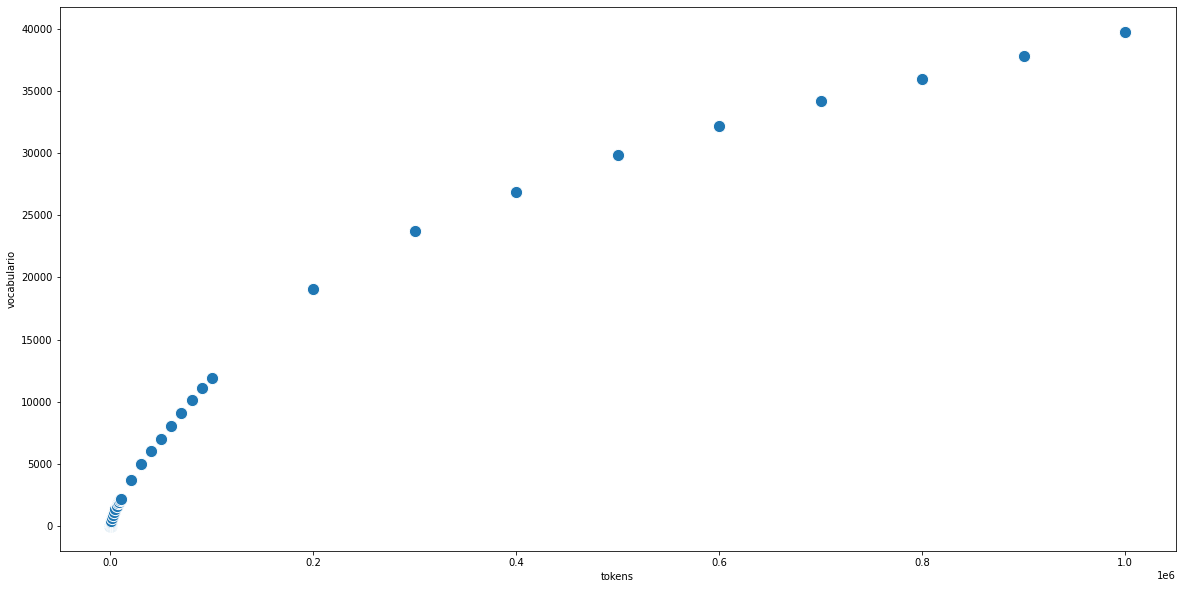

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=df, x="tokens", y="vocabulario", ax = ax, s = 150)